In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta
from decimal import Decimal

# importing pacakge 
import sys         
sys.path.append(r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\libraries')        

from main import *
from FinancialData import *

## Data extraction & Portfolio construction :

In [4]:
ZCR = ZC_Data_extractor(r"C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\ZC Curve")
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

In [5]:
nbr_swap = 400

portfolio = IrsPortfolio(nbr_swap, first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=list(np.arange(1, 7 + 0.5, 0.5)),
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999)


portfolio.print_as_dict()

{'first_reset_date': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0

In [6]:
port_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\portfolio'
portfolio.save_as_pickle(port_path, '\port400irs1fx')

## Model parameters & diffusion :

In [7]:
#LGM params
sig = 0.005 
lam = 0.01

#Diffusion params
T = portfolio.last_maturity
n =  int(T*360) +1 
NBR_SCENARIOS = 10000

tt= time()
diffusion =Diffusion(0, T, n, sig, lam, NBR_SCENARIOS, pb_measure='Terminal at t')
print( 'Diffusion Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )



Diffusion Time 0:00:00


In [8]:
# SAVE diffusion
diff_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\diffusion'
diffusion.save_as_pickle(diff_path,'\MC10000p400swap1fx')

## CVA calculation : 

In [9]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.005

Calulcaltion for 50 is Done ------
Calulcaltion for 100 is Done ------
Calulcaltion for 300 is Done ------
Calulcaltion for 500 is Done ------
Total Calculation Time : 0:39:42


,Discretization,Mtm,CVA,Computation Time
0,50.0,-54507.57,439.34,99.98
1,100.0,-54507.57,432.99,213.78
2,300.0,-54507.57,434.54,771.01
3,500.0,-54507.57,434.74,1296.23


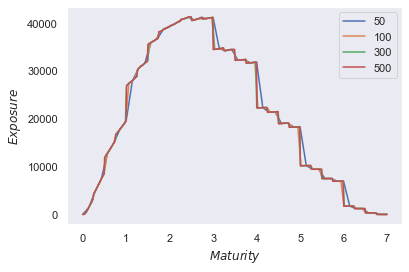

In [10]:
import pickle
img_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Images'
# Save Results :
result_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Full MC'


discretisations = [50,100,300,500]

mtm = np.mean(portfolio.Mtm(0, diffusion,ZC))
benchmark_df =  pd.DataFrame(columns=['Discretization ', 'Mtm' ,'CVA', 'Computation Time'])

start = time()
for n in discretisations :
    time_grid = np.linspace(0,T,n)
    
    mc_start = time()
    
    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, ZC) for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    benchmark_df.loc[len(benchmark_df)] = [ round(n) , mtm,cva, time() - mc_start]
    
    with open(result_path+'\EE_MC_P400swapfX1' ,'wb') as f:
        pickle.dump(benchmark_df,f)
        pickle.dump(EE,f)
   
    plt.plot(time_grid, EE, label=str(n))
    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.savefig(img_path+'\EE_MC_P400swapfX1'+'.png')
    
    print('Calulcaltion for '+str(n)+' is Done ------')
    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))
benchmark_df.round(2)

In [ ]:
benchmark_df.round(1)

In [ ]:
# Save Results :
import pickle
result_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Full MC'
with open(result_path+'\EE_MC_P400swapfX1' ,'wb') as f:
    pickle.dump(benchmark_df,f)
    pickle.dump(EE,f)

### Convergence Test with respect to the number of simulations :

In [11]:
scenarios = [ 20000, 30000, 40000, 50000,60000,70000,80000,90000, 100000]
diffusions = [diffusion]
for NBR_SCENARIOS in scenarios :
    tt= time()
    diffusions.append( Diffusion(0, T, n, sig, lam, NBR_SCENARIOS, pb_measure='Terminal at t'))
    print( 'Diffusion Time for '+str(NBR_SCENARIOS)+' scenarios',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )


Diffusion Time for 20000 scenarios 0:00:00
Diffusion Time for 30000 scenarios 0:00:00
Diffusion Time for 40000 scenarios 0:00:01
Diffusion Time for 50000 scenarios 0:00:01
Diffusion Time for 60000 scenarios 0:00:01
Diffusion Time for 70000 scenarios 0:00:01
Diffusion Time for 80000 scenarios 0:00:01
Diffusion Time for 90000 scenarios 0:00:01
Diffusion Time for 100000 scenarios 0:00:02


Calulcaltion for 40000 is Done ------
Calulcaltion for 60000 is Done ------
Calulcaltion for 80000 is Done ------
Calulcaltion for 100000 is Done ------
Total Calculation Time : 4:28:12


,Simulations Number,CVA MC GPR,Computation Time
0,40000,434,1053
1,60000,431,2006
2,80000,431,3165
3,100000,431,9866


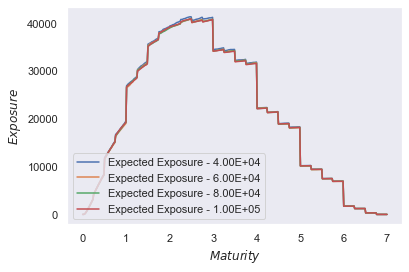

In [15]:
benchmark_convergence_df =  pd.DataFrame(columns=['Simulations Number', 'CVA' , 'Computation Time'])

scenarios = [ 10000,  20000, 30000, 40000, 60000,80000,100000]
start = time()
for n in scenarios :
    time_grid = np.linspace(0,T,500)
    
    mc_start = time()
    
    diff = diffusions[scenarios.index(n)]
    
    EE = np.array([ Expected_exposure_MC(t, portfolio, diff, ZC) if 0<t and t<T else 0 for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    benchmark_convergence_df.loc[len(benchmark_convergence_df)] = [ round(n) , cva, time() - mc_start]
    
    n_decimal = '%.2E' % Decimal(str(n)) if n > 10000 else str(n)
    plt.plot(time_grid, EE, label="Expected Exposure - "+n_decimal)
    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)

    print('Calulcaltion for '+str(n)+' is Done ------')

    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))
benchmark_convergence_df.astype(int) 

# It's CVA MC not CVA mc gpr

In [121]:
benchmark_convergence_df.astype(int)

,Simulations Number,CVA,Computation Time
0,10000,434,1822
1,20000,431,2041
2,40000,434,1053
3,60000,431,2006
4,80000,431,3165
5,100000,431,9866


In [119]:
with open(result_path+'\CVA_MC_convergence_P400swapfX1' ,'wb') as f:
    pickle.dump(benchmark_convergence_df,f)

We converge with 60000 simulations, we recalculate as we didn't saved the EE

In [111]:
n = 60000
diff = Diffusion(0, T, int(T*360) +1 , sig, lam, n, pb_measure='Terminal at t')

In [113]:
# SAVE diffusion
diff_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\diffusion'
diff.save_as_pickle(diff_path,'\MC60000p400swap1fx')

5677.048319578171
Calulcaltion for 60000 is Done ------


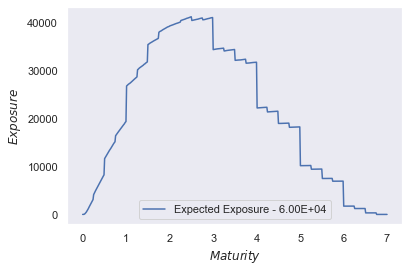

In [114]:

time_grid = np.linspace(0,T,500)

mc_start = time()

EE = np.array([ Expected_exposure_MC(t, portfolio, diff, ZC) if 0<t and t<T else 0 for t in time_grid])
PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
Y = (1-R)*EE*PD
cva = (np.diff(time_grid)*Y[1:]).sum()

print(time() - mc_start)

n_decimal = '%.2E' % Decimal(str(n)) if n > 10000 else str(n)
plt.plot(time_grid, EE, label="Expected Exposure - "+n_decimal)
plt.legend()
plt.xlabel(r"$Maturity$")
plt.ylabel(r"$Exposure$")
plt.grid(False)

print('Calulcaltion for '+str(n)+' is Done ------')

In [116]:
with open(result_path+'\EE_MC_converged60000_P400swapfX1' ,'wb') as f:
    pickle.dump(EE,f)